In [17]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [18]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [19]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


<Axes: >

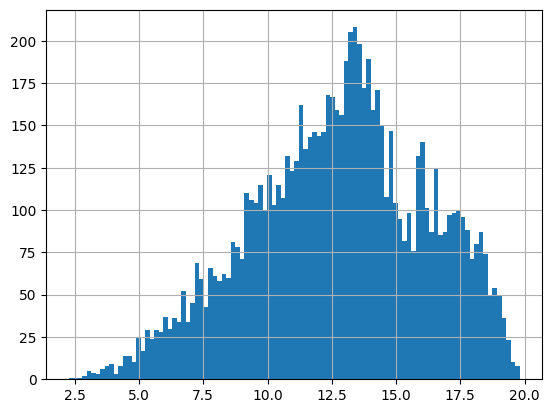

In [20]:
predict.max(axis=1).hist(bins=100)

In [21]:
# min-max normalization
predict = predict.apply(lambda x: np.log(1 + np.exp(x)), axis=1)
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [22]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.257560,0.083064,0.000000,0.053973,0.282588,0.322815,0.322815,5,Walking,Walking
1,0.039920,0.000000,0.490490,0.300848,0.113302,0.055439,0.490490,2,Sitting,Sitting
2,0.283220,0.000000,0.010029,0.084436,0.347397,0.274919,0.347397,4,Upstairs,Upstairs
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,1,Jogging,Jogging
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,3,Standing,Standing
5,0.146047,0.017134,0.000000,0.059657,0.227783,0.549379,0.549379,5,Walking,Walking
6,0.482250,0.025148,0.000000,0.070823,0.287404,0.134375,0.482250,0,Downstairs,Downstairs
7,0.357108,0.000000,0.079185,0.087397,0.224663,0.251647,0.357108,0,Downstairs,Downstairs
8,0.101614,0.594874,0.139825,0.063582,0.000000,0.100104,0.594874,1,Jogging,Jogging
9,0.223991,0.034359,0.000000,0.077907,0.165650,0.498093,0.498093,5,Walking,Walking


Accuracy:  0.9520456476872647


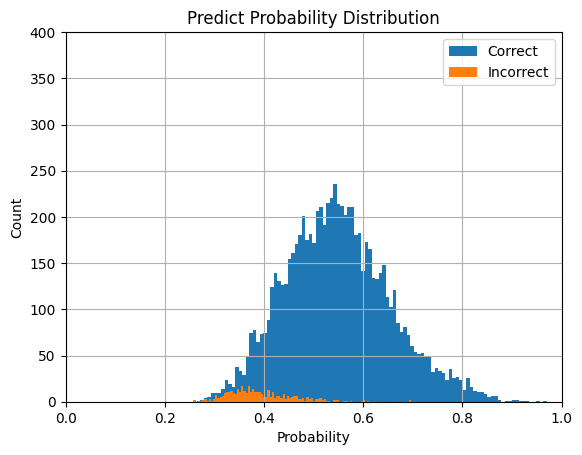

In [23]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [24]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.541437
std       0.109874
min       0.257692
max       0.970451
median    0.538239
Name: predict_probability, dtype: float64

In [25]:
thresholds = [0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        # 'confidence_count': len(df_confidence),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS[:len(cm)], columns=LABELS[:len(cm)])
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_4934/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.952046,1.000000,0.000000,0.000000
0.4,0.979669,0.901663,0.698765,0.098337
0.5,0.993693,0.635183,0.879534,0.364817
0.6,0.997849,0.282263,0.934032,0.717737
0.7,1.000000,0.081826,0.947772,0.918174
0.8,1.000000,0.016147,0.951259,0.983853
0.9,1.000000,0.001093,0.951993,0.998907


# process to gaussian

Before standardization
std: 0.10987372546073579
--- After standardization ---
std: 0.9999999999999999


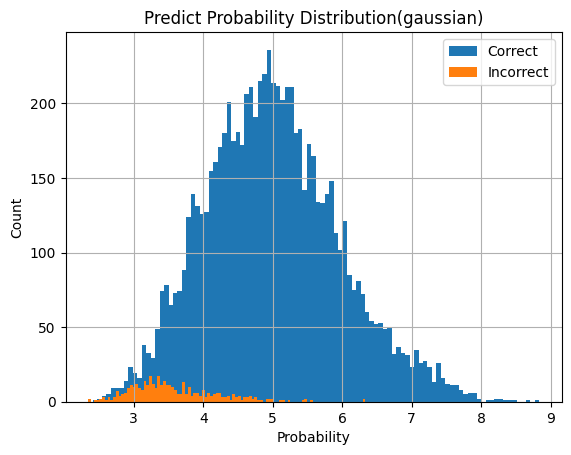

In [26]:
print("Before standardization")
std = df["predict_probability"].std()
print(f"std: {std}")
df["predict_probability_gaussian"] = df["predict_probability"].apply(lambda x: x / std)
print("--- After standardization ---")
std = df["predict_probability_gaussian"].std()
print(f"std: {std}")
df.loc[df.true_label==df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
plt.title('Predict Probability Distribution(gaussian)')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [27]:
thresholds = [0, 6, 8,  9, 10]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_gaussian'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_4934/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_4934/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_4934/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0,0.952046,1.000000,0.000000,0.000000
6,0.998270,0.140342,0.944499,0.859658
8,1.000000,0.001335,0.951982,0.998665
9,0.000000,0.000000,0.952046,1.000000
10,0.000000,0.000000,0.952046,1.000000


# process to torncurve

## 1 - (1 - x) ** 2

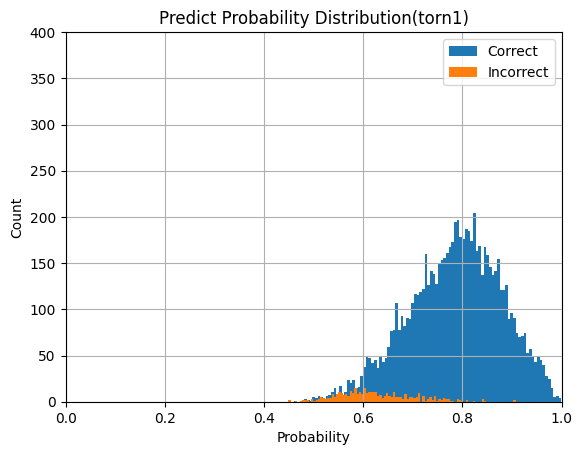

In [28]:
torn1_function = lambda x: 1-(1-x)**2
df["predict_probability_torn1"] = df["predict_probability"].apply(torn1_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn1'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn1'].hist(bins=100)
plt.title('Predict Probability Distribution(torn1)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [29]:
thresholds = [0, 0.5, 0.6, 0.7, 0.8]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn1'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_4934/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.952046,1.000000,0.000000,0.000000
0.5,0.953483,0.996965,0.480000,0.003035
0.6,0.970284,0.951924,0.590909,0.048076
0.7,0.988250,0.785237,0.819672,0.214763
0.8,0.997529,0.442151,0.915996,0.557849


## 1/ln(2) * ln(1+x)

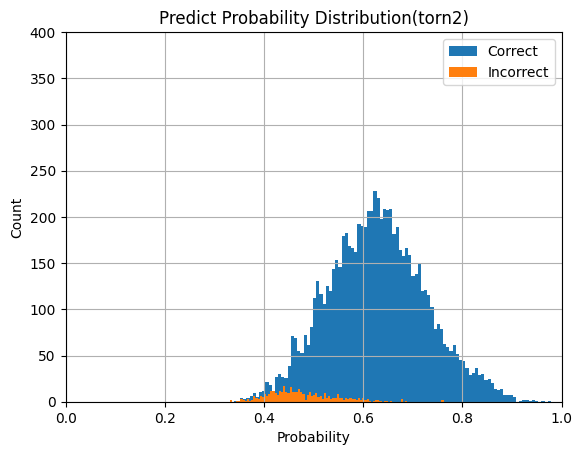

In [30]:
torn2_function = lambda x: (1/np.log(2))*np.log(1+x)
df["predict_probability_torn2"] = df["predict_probability"].apply(torn2_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn2'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn2'].hist(bins=100)
plt.title('Predict Probability Distribution(torn2)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [31]:
thresholds = [0, 0.5, 0.55, 0.6, 0.65]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn2'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_4934/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.952046,1.000000,0.000000,0.000000
0.50,0.982720,0.878232,0.730808,0.121768
0.55,0.990131,0.750395,0.837549,0.249605
0.60,0.995197,0.581401,0.892111,0.418599
0.65,0.997784,0.383513,0.923592,0.616487


/home/nakagawaren/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


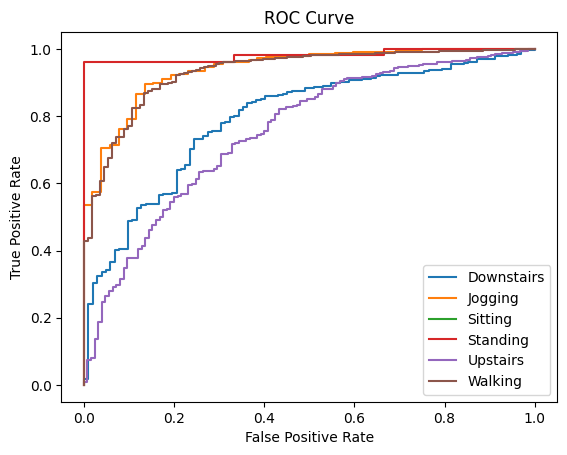

In [32]:
from sklearn.metrics import roc_curve

LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
for label in LABELS:
    fpr, tpr, thresholds = roc_curve(df.loc[df.predict_label==label, 'true_label'], df.loc[df.predict_label==label, "predict_probability"], pos_label=label)
    plt.plot(fpr, tpr, label=label)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()